In [1]:
#
#* 데이터 경로 설정
root_dir = !pwd
root_dir = root_dir[0]
# !mkdir -p data_demo
# %cd data_demo
# !gdown 1wjuiVcO92Rqer5gLk-X7hINfe4PCMQmu
# !pip install tqdm
# !unzip -o 5LpN3gDmAk7_1.zip | tqdm --desc extracted --unit files --unit_scale --total `unzip -l 5LpN3gDmAk7_1.zip | tail -n 1 | xargs echo -n | cut -d' ' -f2` > /dev/null
# %cd ..
import os
#data_dir = "/home/hong/capstone/vlmaps/data_custom"
scene_id = "office_0_1"
data_dir = os.path.join(root_dir, "Data/habitat_sim/vlmaps_dataset", scene_id) #vlmaps_dataset
version = "tracking"
#
#* 갖고있는 depth, rgb 이미지를 이용해 비디오로 시각화해주는 작업
#* 단순 시각화용일 뿐이며, VLMaps 제작이나 이후 작업에 사용되지는 않음
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

In [2]:
# @title Helper functions for video creation and display
import sys
import os
import imageio
import numpy as np
import cv2
import tqdm
from IPython.display import HTML
from base64 import b64encode

# @markdown if the colab instance doesn't have GPU, untick the following checkbox
has_gpu = True # @param {type: "boolean"}
codec = "h264"
if has_gpu:
  codec = "h264_nvenc"

def load_depth(depth_filepath):
    with open(depth_filepath, 'rb') as f:
        depth = np.load(f)
    return depth

def get_fast_video_writer(video_file: str, fps: int = 60):
    if (
        "google.colab" in sys.modules
        and os.path.splitext(video_file)[-1] == ".mp4"
        and os.environ.get("IMAGEIO_FFMPEG_EXE") == "/usr/bin/ffmpeg"
    ):
        # USE GPU Accelerated Hardware Encoding
        writer = imageio.get_writer(
            video_file,
            fps=fps,
            codec=codec,
            mode="I",
            bitrate="1000k",
            format="FFMPEG",
            ffmpeg_log_level="info",
            quality=10,
            output_params=["-minrate", "500k", "-maxrate", "5000k"],
        )
    else:
        # Use software encoding
        writer = imageio.get_writer(video_file, fps=fps)
    return writer

def create_video(data_dir: str, output_dir: str, fps: int = 30):
    
    rgb_dir = os.path.join(data_dir, "rgb")
    depth_dir = os.path.join(data_dir, "depth")
    rgb_out_path = os.path.join(output_dir, "rgb.mp4")
    depth_out_path = os.path.join(output_dir, "depth.mp4")
    rgb_writer = get_fast_video_writer(rgb_out_path, fps=fps)
    depth_writer = get_fast_video_writer(depth_out_path, fps=fps)

    rgb_list = sorted(os.listdir(rgb_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))
    depth_list = sorted(os.listdir(depth_dir), key=lambda x: int(
        x.split("_")[-1].split(".")[0]))

    rgb_list = [os.path.join(rgb_dir, x) for x in rgb_list]
    depth_list = [os.path.join(depth_dir, x) for x in depth_list]
    pbar = tqdm.tqdm(total=len(rgb_list), position=0, leave=True)
    for i, (rgb_path, depth_path) in enumerate(zip(rgb_list, depth_list)):
        bgr = cv2.imread(rgb_path)
        rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

        depth = load_depth(depth_path)
        depth_vis = (depth / 10 * 255).astype(np.uint8)

        depth_color = cv2.applyColorMap(depth_vis, cv2.COLORMAP_JET)

        rgb_writer.append_data(rgb)
        depth_writer.append_data(depth_color)
        pbar.update(1)
    rgb_writer.close()
    depth_writer.close()

def show_video(video_path, video_width = 1080):
   
    video_file = open(video_path, "r+b").read()
  
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>""")

def show_videos(video_paths, video_width = 1080):
    html = ""
    for video_path in video_paths:
        video_file = open(video_path, "r+b").read()
      
        video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
        html += f"""<video width={video_width} autoplay controls><source src="{video_url}"></video>
                 """
    return HTML(html)

In [3]:
# create_video(data_dir, data_dir, fps=30)

In [4]:
# show rgb and depth
# show_videos([data_dir + "/rgb.mp4", data_dir + "/depth.mp4"])


In [5]:
#
#* setup VLMaps parameters
# @markdown meters per cell size
cs = 0.05 # @param {type: "number"} #* 셀 크기 당 미터 단위
# @markdown map resolution (gs x gs)
gs = 1000 # @param {type: "integer"} #* 맵의 해상도 (그리드 수 _ 정수 단위)
# @markdown camera height (used for filtering out points on the floor)
camera_height = 1.5 # @param {type: "number"} #* 카메라 높이 (바닥에 있는 점을 필터링하는 데 사용)
# @markdown depth pixels subsample rate
depth_sample_rate = 10 # @param {type: "integer"} #* depth 정보의 픽셀 sampling rate
# @markdown data where rgb, depth, pose are loaded and map are saved
data_dir = data_dir # @param {type: "string"} #* 데이터 경로

In [6]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.mapping_utils import load_map, get_new_pallete, get_new_mask_pallete
from utils.clip_utils import get_text_feats
from utils.matterport3d_categories import mp3dcat #* 여기엔 그 장애물이 리스트 형태로 저장되어있음
import clip

In [7]:
use_self_built_map = True # @param {type: "boolean"} 
map_save_dir = os.path.join(data_dir, "map")
if use_self_built_map:
    map_save_dir = os.path.join(data_dir, f"map/{scene_id}_{version}")
os.makedirs(map_save_dir, exist_ok=True)

color_top_down_save_path = os.path.join(map_save_dir, f"color_top_down_{version}.npy")
grid_save_path = os.path.join(map_save_dir, f"wall_{version}.npy")
obstacles_save_path = os.path.join(map_save_dir, f"obstacles_{version}.npy")
weight_save_path = os.path.join(map_save_dir, f"weight_{version}.npy")
background_grid_save_path = os.path.join(map_save_dir, f"background_grid_{version}.npy")
category_map_save_path = os.path.join(map_save_dir, f"category_map_{version}.npy")
instance_map_save_path = os.path.join(map_save_dir, f"instance_map_{version}.npy")
# gt_save_path = os.path.join(map_save_dir, f"grid_lseg_gt.npy")
print(data_dir)

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/office_0_3


[0 1]


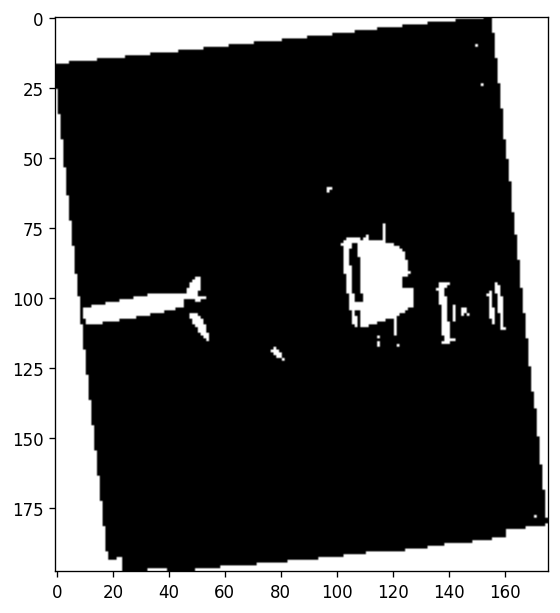

In [8]:
obstacles = load_map(obstacles_save_path)
color_top_down = load_map(color_top_down_save_path)
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(np.unique(obstacles))
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

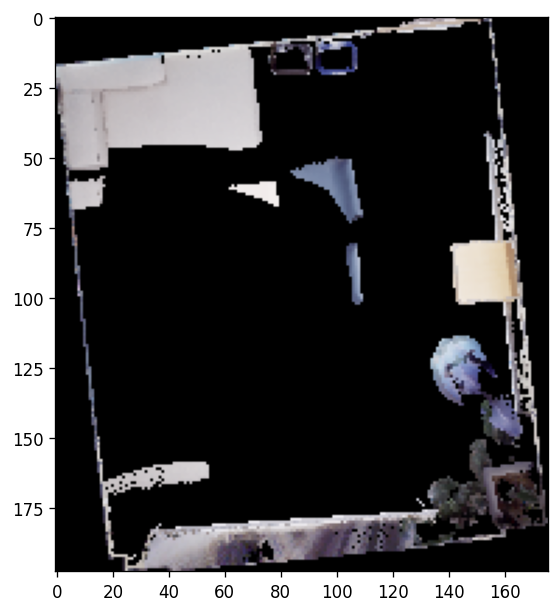

In [9]:
color_top_down = load_map(color_top_down_save_path)
color_top_down = color_top_down[xmin:xmax+1, ymin:ymax+1]
color_top_down_pil = Image.fromarray(color_top_down)
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(color_top_down_pil)
plt.savefig(os.path.join(map_save_dir, f"rgbtopdown_{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()

In [10]:
%%capture
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:

grid = load_map(grid_save_path)
print(grid)
print(grid.shape)
print(grid_save_path)
grid_pil = Image.fromarray(grid[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(grid_pil)
plt.savefig(os.path.join(map_save_dir, f"rgbtopdown_{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()
obstacles_pil = Image.fromarray(obstacles[xmin:xmax+1, ymin:ymax+1])
plt.figure(figsize=(8, 6), dpi=120)
plt.imshow(obstacles_pil, cmap='gray')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/office_0_3/map/office_0_3_seem/wall_seem.npy'

In [12]:
# background_grid = load_map(background_grid_save_path)
# background_grid = background_grid[xmin:xmax+1, ymin:ymax+1]
# print(background_grid.shape)
# bbackground_grid = np.zeros_like(background_grid)
# bbackground_grid[background_grid == 1] = 2
# bbackground_grid[background_grid == 2] = 1

In [13]:
from seem.base_model import build_vl_model
model = build_vl_model("seem", input_size = 360)

[*] model loaded


In [14]:
# query = ["void","table in the kitchen"]
query = [
    "void",
    "wall",
    "floor",
    "chair",
    "door",
    "table",
    "picture",
    "cabinet",
    "cushion",
    "window",
    "sofa",
    "bed",
    "curtain",
    "chest_of_drawers",
    "plant",
    "sink",
    "stairs",
    "ceiling",
    "toilet",
    "stool",
    "towel",
    "mirror",
    "tv_monitor",
    "shower",
    "column",
    "bathtub",
    "counter",
    "fireplace",
    "lighting",
    "beam",
    "railing",
    "shelving",
    "seating",
    "blinds",
    "gym_equipment",
    "board_panel",
    "furniture",
    "appliances",
    "clothes",
    "objects",
    # "carpet"
]
# query = [
#     "void",
#     "wall",
#     "floor",
#     "chair",
#     "door",
#     "table",
#     "picture",
#     "cabinet",
#     "cushion",
#     "window",
#     "sofa",
#     "bed",
#     "curtain",
#     "sink",
#     "stairs"
# ]

# query = [
#     "void",
# #    "floor",
#     "bed_room in a scene"
# ]
t_emb = model.encode_prompt(query, task="default")

aa = t_emb.cpu().numpy()
print(aa.shape)

# query = ["table","computer"]
# t_emb = model.encode_prompt(query, task="default")
# aa = t_emb.cpu().numpy()

# print(aa.shape)

# qq = ["computer on the table"]
# tt = model.encode_prompt(qq, task="default")
# bb = tt.cpu().numpy()



(40, 512)


In [15]:
import pickle

embeddings_path = os.path.join(map_save_dir, f"instance_dict_{version}.pkl")

print(embeddings_path)


#"/home/hong/VLMAPS/vlseem/Data/habitat/vlmaps_dataset/2t7WUuJeko7_2_mini/map/instance_dict_dummy_geo_dist4.pkl"

with open(embeddings_path, 'rb') as f:
    embeddings = pickle.load(f)

no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(embeddings.keys())

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_obstacle/instance_dict_obstacle.pkl


FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_obstacle/instance_dict_obstacle.pkl'

(370, 471)
embeddings: 145


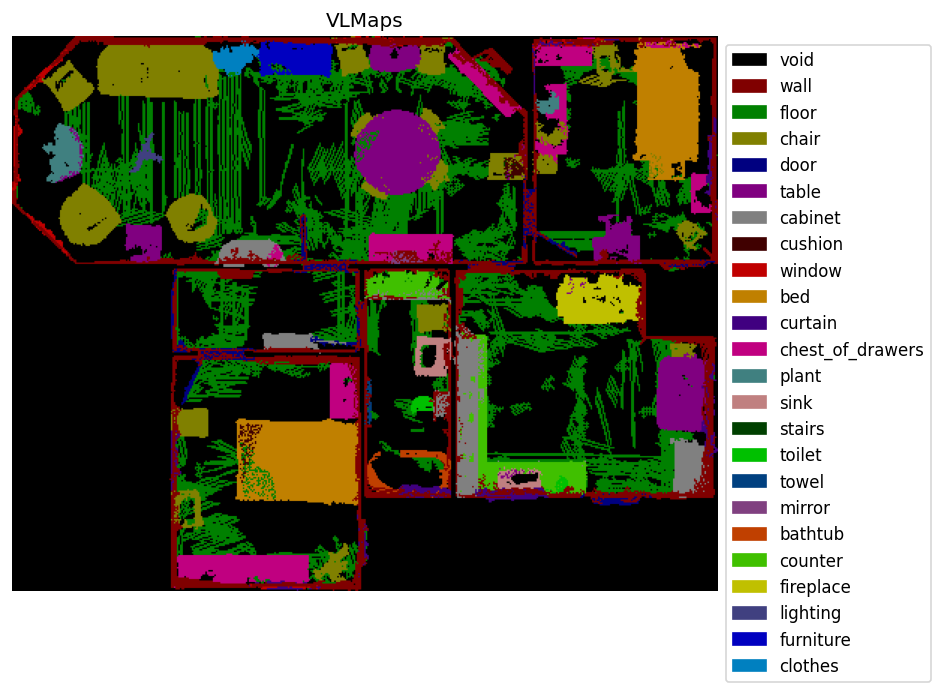

/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_1125test_wallfloor/indexmap_height1125test_wallfloor.png


In [16]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                if key == 2 :continue
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                if max_height > candidate_height:
                    max_height = candidate_height
                    candidate_val = candidate
                # if candidate_observed > max_observed:
                #     max_observed = candidate_observed
                #     candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_height{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()
print(os.path.join(map_save_dir, f"indexmap_height{version}.png"),)

In [17]:
# # 108 395
# print(embeddings[1]["avg_height"])
# print(embeddings[5]["avg_height"])
# print(embeddings[6]["avg_height"])

(370, 471)
embeddings: 145


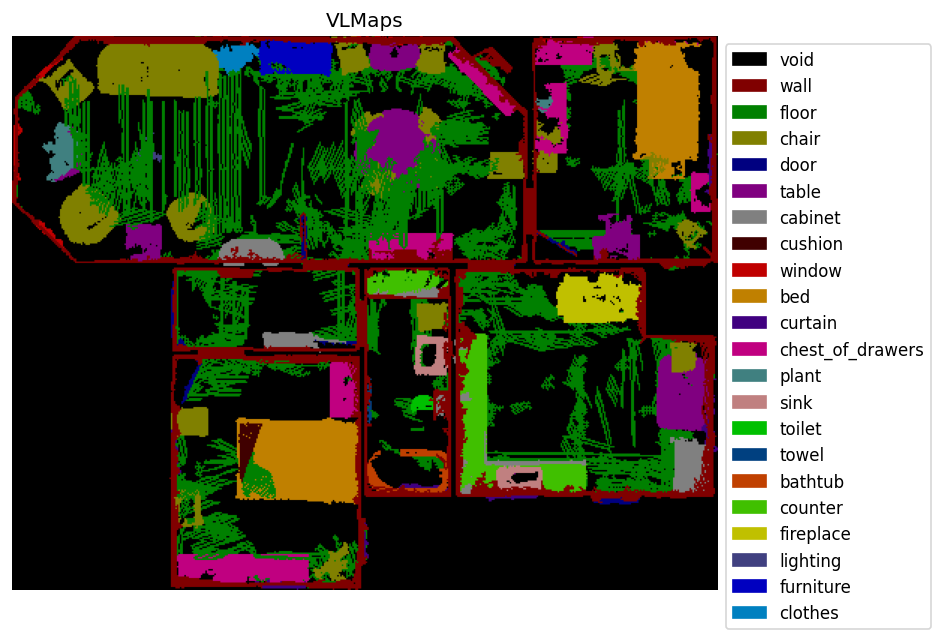

In [18]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                if key == 2 :continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = -embeddings[key]["avg_height"]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                if max_height > candidate_height:
                    max_height = candidate_height
                    candidate_val = candidate
                # if candidate_observed > max_observed:
                #     max_observed = candidate_observed
                #     candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(ggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_avg{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()

(370, 471)
embeddings: 145


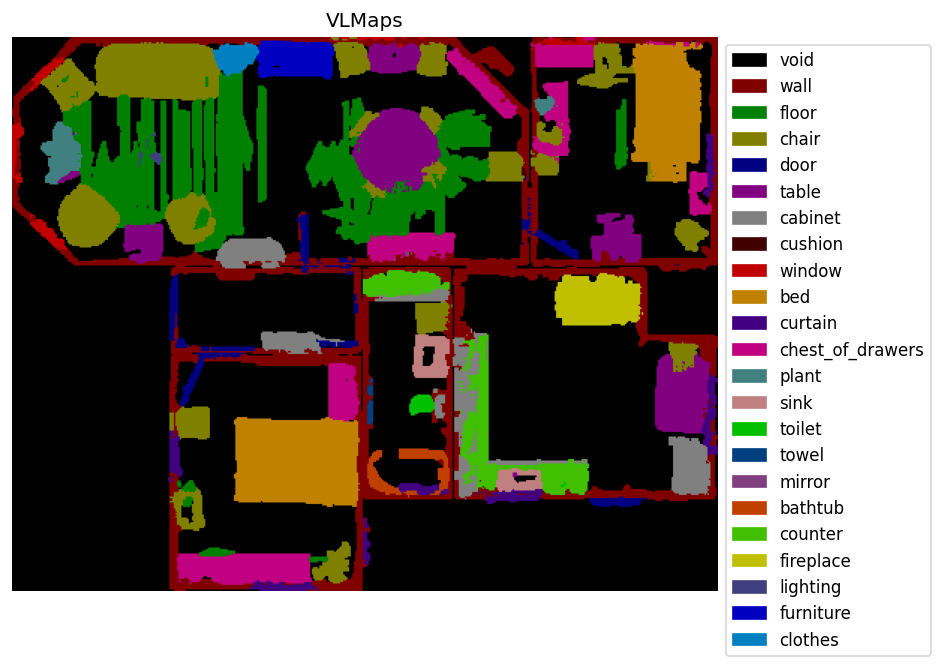

In [19]:
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)
# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.empty_like(grid, dtype=dict)
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        ggrid_map[i,j] = {}
        
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        # if len(grid[i,j].keys()) == 1:
        #     # print(grid[i,j][0])
        for key in grid[i,j].keys():
            if key == 2 :continue
            new_key = predicts[list(embeddings.keys()).index(key)]
            ggrid_map[i,j][new_key] = grid[i,j][key][2]
                # ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        # else:
        #     max_conf = 0
        #     max_height = 0
        #     # candidate_val = 0
        #     for key, val in grid[i,j].items():
        #         # print(arg)
        #         # print(predicts.shape)
        #         candidate = predicts[list(embeddings.keys()).index(key)]
        #         candidate_conf = val[0]
        #         candidate_height = val[2]
        #         # if max_conf < candidate_conf:
        #         #     max_conf = candidate_conf
        #         #     candidate_val = candidate
        #         if max_height < candidate_height:
        #             max_height = candidate_height
        #             candidate_val = candidate
        #     ggrid_map[i,j] = candidate_val

center_weight = 3
gggrid_map = np.zeros_like(ggrid_map, dtype=np.uint8)
grid_upper = np.empty((ggrid_map.shape[0]+1, ggrid_map.shape[1]+1), dtype=dict)
for i in range(ggrid_map.shape[0]+1):
    for j in range(ggrid_map.shape[1]+1):
        grid_upper[i,j] = {}
grid_upper[1:,1:] = ggrid_map
for i in range(1,gggrid_map.shape[0]+1):
    for j in range(1,gggrid_map.shape[1]+1):
        candidate = grid_upper[i-1:i+2,j-1:j+2]
        item_dict = {}
        for candidate_i in range(candidate.shape[0]):
            for candidate_j in range(candidate.shape[1]):
                if candidate_i == i and candidate_j == j:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += center_weight #* val
                        else: item_dict[key] = center_weight #* val
                else:
                    # if len(candidate[candidate_i,candidate_j]) == 0: continue
                    for key, val in candidate[candidate_i,candidate_j].items():
                        if key in item_dict.keys():
                            item_dict[key] += 1 #* val
                        else: item_dict[key] = 1 #*  val
        if len(item_dict) ==0:
            gggrid_map[i-1,j-1] = 0
            continue
        max_key = max(item_dict, key=item_dict.get)
        gggrid_map[i-1,j-1] = max_key


floor_mask = gggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(gggrid_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.savefig(os.path.join(map_save_dir, f"indexmap_mode{version}.png"), bbox_inches='tight', pad_inches=0.1)
plt.show()

In [20]:
category_map = load_map(category_map_save_path)
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0
print(grid.shape)
id_list = []
instance_feat = []
print("embeddings:",len(embeddings.keys()))
# print(embeddings.keys())
# print("grid:",grid.shape)
ids=[]
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        for arg in grid[i,j].keys():
            if arg not in ids:
                ids.append(arg)

# np.set_printoptions(threshold=np.inf)
# print(ids)
# print("grid ids:",len(ids))
# print(grid)
# print(embeddings)
for id, val in embeddings.items():
    id_list.append(id)
    instance_feat.append(val["embedding"])
instance_feat = np.array(instance_feat)

# instance_feat = np.vstack([aa[:2,:],instance_feat])

# print("instance_feat:",instance_feat.shape)
scores_list = instance_feat @ aa.T
# print("scores_list:",scores_list)
# key_list = list(embeddings.keys())
# print(key_list)
# print(scores_list.shape)
predicts = np.argmax(scores_list, axis=1)
ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# ggrid_map[background_grid == 1] = 2
# ggrid_map[background_grid == 2] = 1
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if len(grid[i,j].keys()) == 0:
            continue
        if len(grid[i,j].keys()) == 1:
            # print(grid[i,j][0])
            for key in grid[i,j].keys():
                # if key in [1,0]:
                #     ggrid_map[i,j]=key
                #     continue
                ggrid_map[i,j] = predicts[list(embeddings.keys()).index(key)]
        else:
            max_conf = 0
            max_height = 50000
            max_observed = 0
            for key, val in grid[i,j].items():
                # print(arg)
                # print(predicts.shape)
                # if key in [1,0]: continue
                candidate = predicts[list(embeddings.keys()).index(key)]
                candidate_conf = val[0]
                candidate_height = val[1]
                candidate_observed = val[2]
                # if max_conf < candidate_conf:
                #     max_conf = candidate_conf
                #     candidate_val = candidate
                # if max_height > candidate_height:
                #     max_height = candidate_height
                #     candidate_val = candidate
                if candidate_observed > max_observed:
                    max_observed = candidate_observed
                    candidate_val = candidate
            ggrid_map[i,j] = candidate_val
floor_mask = ggrid_map == 2
# print("ggrid_map",ggrid_map.shape)
new_pallete = get_new_pallete(len(query))
mask, patches = get_new_mask_pallete(category_map, new_pallete, out_label_flag=True, labels=query)
seg = mask.convert("RGBA")
seg = np.array(seg)
# seg[no_map_mask] = [225, 225, 225, 255]
# seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)



# ggrid_map_save_path = os.path.join(map_save_dir, f"ggrid_{mask_version}.npy")
# np.save(ggrid_map_save_path, ggrid_map)

plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/2t7WUuJeko7_2/map/2t7WUuJeko7_2_1125test_wallfloor/category_map_1125test_wallfloor.npy'

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

instance_map = load_map(instance_map_save_path)

# unique한 인스턴스 인덱스 값을 가져옴
unique_indices = np.unique(instance_map)
print(len(unique_indices))
num_colors = len(unique_indices)

# 임의의 색상 리스트 생성
colors = plt.cm.nipy_spectral(np.linspace(0, 1, num_colors))
cmap = ListedColormap(colors)

# 인덱스 값이 각 고유 인덱스에 매핑되도록 색상 매핑
index_to_color = {idx: i for i, idx in enumerate(unique_indices)}
colored_map = np.vectorize(index_to_color.get)(instance_map)

# 시각화
plt.figure(figsize=(10, 10))
plt.imshow(colored_map, cmap=cmap)  
plt.colorbar(ticks=range(num_colors), label='Index Value')  # 고유한 색상 바 추가
plt.title('Map Visualization by Index Values')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/nvme0n1/hong/VLMAPS/InstanceSeemMap/Data/habitat_sim/vlmaps_dataset/1125test_wallfloor/map/1125test_wallfloor_inf3/instance_map_inf3.npy'

In [18]:
import numpy as np

if np.all((instance_map == 1) == (category_map == 2)):
    print("same")


NameError: name 'instance_map' is not defined

In [19]:
for id in np.unique(instance_map):
    if id ==0:continue
    ha = np.zeros_like(instance_map)
    ha[instance_map == id] = 1

    plt.clf()  # 이전 이미지 지우기
    # name = predicts[id-1]
    # print(query[name])
    print(ha.shape)
    print(np.sum(ha))
    plt.imshow(ha, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()

NameError: name 'instance_map' is not defined

In [26]:
temp1 = 90
temp2 = 196

temp1_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
temp2_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# temp1_feat = instance_feat[temp1]

temp1_feat = embeddings[temp1]["embedding"]
temp1_mask = embeddings[temp1]["mask"]
temp1_feat = temp1_feat / np.linalg.norm(temp1_feat)
# temp2_feat = instance_feat[temp2]
temp2_feat = embeddings[temp2]["embedding"]
temp2_mask = embeddings[temp2]["mask"]
temp2_feat = temp2_feat / np.linalg.norm(temp2_feat)


print(f"Size: {np.sum(temp1_mask)} {np.sum(temp2_mask)}")


semSim = temp1_feat @ temp2_feat.T
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        if temp1 in grid[i,j]:
            temp1_map[i,j] = 1
        if temp2 in grid[i,j]:
            temp2_map[i,j] = 1
print(f"size2: {np.sum(temp1_map)} {np.sum(temp2_map)}")
union_map = np.logical_or(temp1_map, temp2_map).astype(int)
intersection_map = np.logical_and(temp1_map, temp2_map).astype(int)

uu=np.logical_or(temp1_mask, temp2_mask).astype(int)
ii=np.logical_and(temp1_mask, temp2_mask).astype(int)
iiou = np.sum(ii) / np.sum(uu)
print(f"IIoU: {iiou:.3f} (for checking the mask is correct)")


iou = np.sum(intersection_map) / np.sum(union_map)


temp1_center = np.argwhere(temp1_map == 1).mean(axis=0)
temp2_center = np.argwhere(temp2_map == 1).mean(axis=0)
center_dist = np.linalg.norm(temp1_center - temp2_center)

# temp1_bbox = calculate_bbox(temp1_map)
# temp2_bbox = calculate_bbox(temp2_map)
# iou_bbox = calculate_iou_bbox(temp1_bbox, temp2_bbox)


print(f"Center Point : temp1 {temp1_center}, temp2 {temp2_center}")
# print(f"bbox IoU: {iou_bbox:.3f}")
print(f"IoU: {iou:.3f}, Center Distance: {center_dist:.3f}")
print(f"Cosine Similarity: {semSim}")

contours1, _ = cv2.findContours(temp1_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours2, _ = cv2.findContours(temp2_map.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


lengths1 = [len(contour) for contour in contours1]
if len(contours1) == 0:
    raise Exception("no contour")
contour1 = contours1[np.argmax(lengths1)].squeeze(axis=1)
lengths2 = [len(contour) for contour in contours2]
contour2 = contours2[np.argmax(lengths2)].squeeze(axis=1)
# haus12 = directed_hausdorff(contour1, contour2)[0]
# haus21 = directed_hausdorff(contour2, contour1)[0]
# hausdorff_distance = (haus12 + haus21) / 2
# print(f"Hausdorff Distance: {hausdorff_distance}")

Size: 369 2369
size2: 369 2369
IIoU: 0.000 (for checking the mask is correct)
Center Point : temp1 [ 21.44715447 197.62059621], temp2 [ 45.48163782 129.8315745 ]
IoU: 0.000, Center Distance: 71.924
Cosine Similarity: 0.970867395401001


In [17]:
# # 좌표에 0이 키값으로 있는 포인트만 선택하여 ggrid_map 생성
# ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
# for i in range(grid.shape[0]):
#     for j in range(grid.shape[1]):
#         if 5 in grid[i, j]:
#             ggrid_map[i, j] = 1  # 0 키를 가진 포인트는 1로 표시

# # 시각화를 위해 1이 있는 곳만 표시
# plt.figure(figsize=(10, 6), dpi=120)
# plt.imshow(ggrid_map, cmap="gray")
# plt.axis('off')
# plt.title("Points with Key 0")
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

# 시각화를 위한 설정
plt.figure(figsize=(10, 6), dpi=120)
print(embeddings.keys())
# k값을 0부터 287까지 변경하면서 시각화
for n,id in enumerate(embeddings.keys()):
    # 좌표에 k가 키값으로 있는 포인트만 선택하여 ggrid_map 생성
    ggrid_map = np.zeros((grid.shape[0], grid.shape[1]), dtype=int)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            if id in grid[i, j]:
                ggrid_map[i, j] = 1  # k 키를 가진 포인트는 1로 표시
    # maskk = embeddings[id]["mask"]
    # print(maskk.shape)
    # print(np.sum(maskk))
    # # 시각화를 위해 1이 있는 곳만 표시
    # plt.clf()  # 이전 이미지 지우기
    # plt.imshow(maskk, cmap="gray")
    if n==0:
        np.save(os.path.join(map_save_dir, f"wall_mask.npy"), ggrid_map)

    plt.clf()  # 이전 이미지 지우기
    name = predicts[n]
    print(query[name])
    print(ggrid_map.shape)

    print(np.sum(ggrid_map))
    plt.imshow(ggrid_map, cmap="gray")


    plt.axis('off')
    plt.title(f"Points with Key {id}")
    plt.draw()  # 현재 상태를 그리기
    plt.pause(0.5)  # 0.5초 간격으로 업데이트 (시간 조정 가능)

    plt.show()


NameError: name 'embeddings' is not defined

<Figure size 1200x720 with 0 Axes>